# EnKF数据同化

## 1 导入相关库

In [1]:
%matplotlib inline
import sys, os
import copy
import datetime as dt
import pcse
from Wofost_opt_NWLP import my_crop_dict, my_agro, ModelRerunner
from pcse.fileinput import YAMLCropDataProvider, CABOFileReader, YAMLAgroManagementReader
from pcse.exceptions import PCSEError, PartitioningError
from pcse.util import WOFOST80SiteDataProvider, WOFOST71SiteDataProvider
from pcse.base import ParameterProvider
from pcse.fileinput import YAMLAgroManagementReader
from pcse.fileinput import ExcelWeatherDataProvider
from pcse.models import Wofost80_NWLP_FD_beta as Wofost80_NWLP_FD
from pcse.models import Wofost72_WLP_FD
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.8.15 (default, Nov  4 2022, 15:16:59) [MSC v.1916 64 bit (AMD64)] 
PCSE version: 5.5.4


In [2]:
data_dir = os.path.join(os.getcwd(), "data")

In [3]:
def isdir_demo(dir_path):
    if not os.path.isdir(dir_path):
        try:
            os.mkdir(dir_path)
        except FileNotFoundError:
            os.makedirs(dir_path)

## 2数据准备

### 2.1 模型输入数据

In [4]:
cropfile = os.path.join(data_dir, 'npkfile', 'wofost_npk.crop')
cropd = CABOFileReader(cropfile)
soilfile = os.path.join(data_dir, 'soil', 'ec3_copy1.soil')
soild = CABOFileReader(soilfile)

In [5]:
sited = WOFOST80SiteDataProvider(WAV=18, NAVAILI=20.5, PAVAILI=50.0, KAVAILI=250.0)

In [6]:
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

In [7]:
with open("./data/npkfile/wofost_npk2022.agro", 'r') as f:
    yaml_agro_2022 = f.read()
with open("./data/npkfile/wofost_npk2021.agro", 'r') as f:
    yaml_agro_2021 = f.read()

In [8]:
weatherfile = os.path.join(data_dir, 'meteo', 'WOFOSTYL.xlsx')
wdp = ExcelWeatherDataProvider(weatherfile)

In [9]:
def overwrite_para(params, param_dict):
    params.clear_override()
    params.set_override("TSUMEM", 125.0)
    params.set_override("TSUM1", 1300)
    params.set_override("TSUM2", 720)
    crop_dict = my_crop_dict()

    for parname, value in param_dict.items():

        tmp_name = parname.split("00")
        if len(tmp_name) == 2:
            var_name, idx1 = tmp_name[0], int(tmp_name[1])
            if var_name == "FLTB" or var_name == "FOTB":
                crop_dict[var_name][idx1] = value
                crop_dict['FSTB'][idx1] = 1 - crop_dict['FLTB'][idx1] - crop_dict['FOTB'][idx1]
                params.set_override(var_name, crop_dict[var_name])
                params.set_override("FSTB", crop_dict["FSTB"])
                # print("%s: %s" % (var_name, parameters[var_name]))
            else:
                crop_dict[var_name][idx1] = value
                params.set_override(var_name, crop_dict[var_name])

        else:
            var_name = parname
            params.set_override(var_name, value)
    return params

In [160]:
param_df = pd.read_csv(os.path.join(data_dir, "opt", "optNWLP", "opt_ZDN180_NWLP_result3.csv"), index_col=0)
param_df.sort_values(by=['rmse'], ascending=True, inplace=True)
parameters_name = param_df.columns.to_list()
parameters_name = parameters_name[1: ]

rows, _ = param_df.shape
df_dict = dict()
for nn in [180]:
    agro = my_agro(yaml_agro_2021, nn)
    modelrerunner = None
    modelrerunner = ModelRerunner(parameters, wdp, agro)
    twso_list = list()
    for i in tqdm([0]):
        p_value = dict()
        for each in parameters_name:
            p_value[each] = param_df.iloc[i][each]
        result = modelrerunner(p_value, flag=True)
        # if result[1][0]['TWSO'] > 8000:
        twso_list.append([i, result[1][0]['TWSO']])
    df1 = pd.DataFrame(twso_list, columns=["id", "TWSO"])
    df1.set_index("id", inplace=True)
    df_dict[str(nn)] = df1

100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


In [161]:
def read_obs(file_path):
    obs_LAI = pd.read_csv(file_path)
    obs_LAI.index = pd.to_datetime(obs_LAI.day)
    obs_LAI.drop("day", axis=1, inplace=True)
    return obs_LAI


def gen_raw_data(df_mo, obs_tagp, obs_lai, path):
    concat1 = pd.concat([df_mo, obs_tagp, obs_lai], axis=1)
    if os.path.isfile(path):
        print("该文件已存在，请检查路径")
    else:
        concat1.to_csv(path)



In [162]:
bio_ml = read_obs("F:\\paper_code\\MLlai\\data\\ml\\ZDN180Y2021_TAGP_ML.csv")
lai_ml = read_obs("F:\\paper_code\\MLlai\\data\\ml\\ZDN180Y2021_LAI_ML.csv")

raw_path = "./data/data4DA/ZDN180Y2021.csv"

gen_raw_data(result[0][["LAI", "TAGP"]], bio_ml, lai_ml, raw_path)


该文件已存在，请检查路径


In [163]:
df_model = result[0]

### 2.2观测数据

In [164]:
pathDA = "./data/data4DA/ZDN180Y2021.csv"
obs_DA = pd.read_csv(pathDA)
obs_DA.index = pd.to_datetime(obs_DA.day).dt.date
obs_DA.drop("day", axis=1, inplace=True)
obs_DA.dropna(axis=0, inplace=True, how="any")


In [175]:
df_model.shape

(123, 29)

In [188]:
df_model["LAI_G"] = df_model.LAI*np.random.normal(1, 0.20, df_model.shape[0])

In [189]:
variables_for_DA = ["LAI", "TAGP"]
dates_of_observation = obs_DA.index.to_list()
observed_lai = obs_DA.LAI_ML.to_numpy()
std_lai = observed_lai * 0.10 # Std. devation is estimated as 10% of observed value                                                                 
observed_tagp = obs_DA.TAGP_ML.to_numpy()
std_tagp = observed_tagp * 0.05 # Std. devation is estimated as 5% of observed value
observations_for_DA = []
# Pack them into a convenient format
for d, lai, errlai, tagp, errtagp in zip(dates_of_observation, observed_lai, std_lai, observed_tagp, std_tagp):
    observations_for_DA.append((d, {"LAI":(lai, errlai), "TAGP":(tagp, errtagp)}))

### 2.3 Plot modelled and observed states
We will now combine the default WOFOST run and the satellite observations in a single figure.

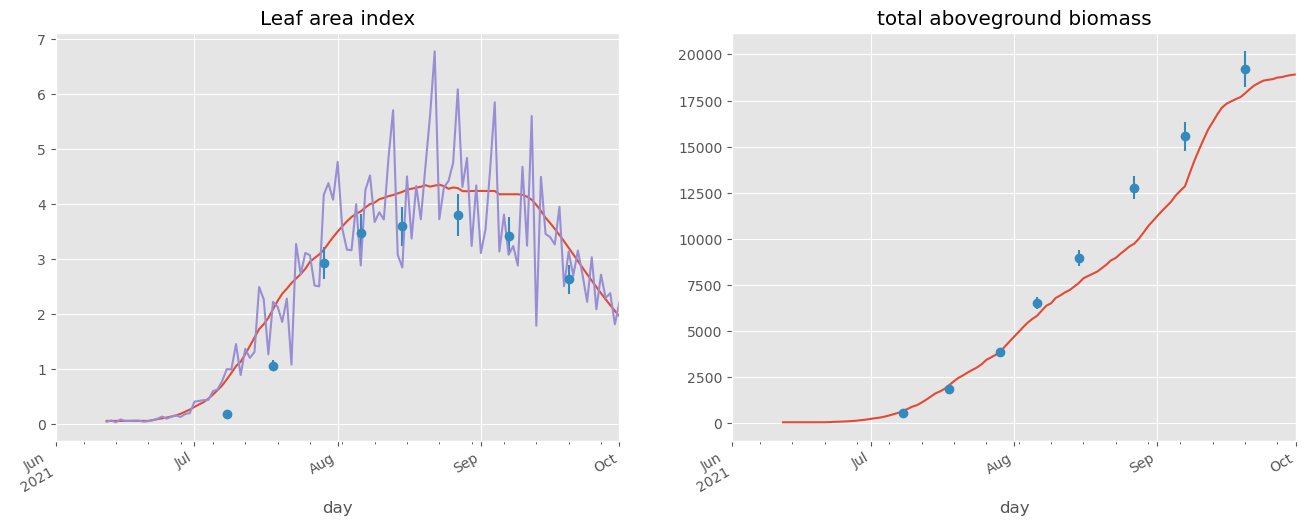

In [190]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
df_model.LAI.plot(ax=axes[0], label="leaf area index")
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
df_model.TAGP.plot(ax=axes[1], label="total aboveground biomass")
axes[1].errorbar(dates_of_observation, observed_tagp, yerr=std_tagp, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("total aboveground biomass")
df_model.LAI_G.plot(ax=axes[0])
fig.autofmt_xdate()

## 3 数据同化

### 3.1 同化集合

In [136]:
ensemble_size = 50
np.random.seed(1354331612)

### 3.2 设置同化参数

**均匀分布**

In [137]:
param_set = pd.read_csv("./data/opt/DA/ZD_DA1.csv", index_col=0)
# 需要调整的参数集
override_parameters = {}
# 初始条件
override_parameters["TDWI"] = np.random.normal(46.79, 2.9545, (ensemble_size))
override_parameters["WAV"] = np.random.normal(18., 1.5, (ensemble_size))
# override_parameters["NAVAILI"] = np.random.normal(20.5, 0.5, (ensemble_size))
# 参数
# override_parameters["SPAN"] = np.random.normal(43.649, 1.826346, (ensemble_size))
# override_parameters["SLATB001"] = np.random.normal(0.0022789, 0.000174 ,(ensemble_size))
# override_parameters["SLATB003"] = np.random.normal(0.001432, 0.0000483, (ensemble_size))
# override_parameters["TMNFTB003"] = np.random.normal(1.117173, 0.038879, (ensemble_size))
# override_parameters["EFFTB003"] = np.random.normal(0.496615, 0.046394, (ensemble_size))
# override_parameters["NMAXLV_TB007"] = np.random.normal(0.010456, 0.000709, (ensemble_size))
# override_parameters["NCRIT_FR"] = np.random.normal(0.750603, 0.02449, (ensemble_size))
for each in param_set.columns:
    override_parameters[each] = np.random.uniform(param_set.loc[2, each], param_set.loc[3, each], (ensemble_size))

# fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,20))
# # Show the sample that was drawn
# for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
#     ax.hist(distr)
#     ax.set_title(par)


**高斯分布**

In [138]:
def add_gaussian_noise(data, data_size, mean=1.0, std=0.05):
    return data*np.random.normal(mean, std, data_size)

In [139]:
par_std = pd.read_csv("./data/opt/DA/opt_ZDN180_DA_result3.csv", index_col=0)
par_std.sort_values(by="rmse", ascending=True, inplace=True)

In [140]:
param_df.iloc[10]["TDWI"]

67.73984081

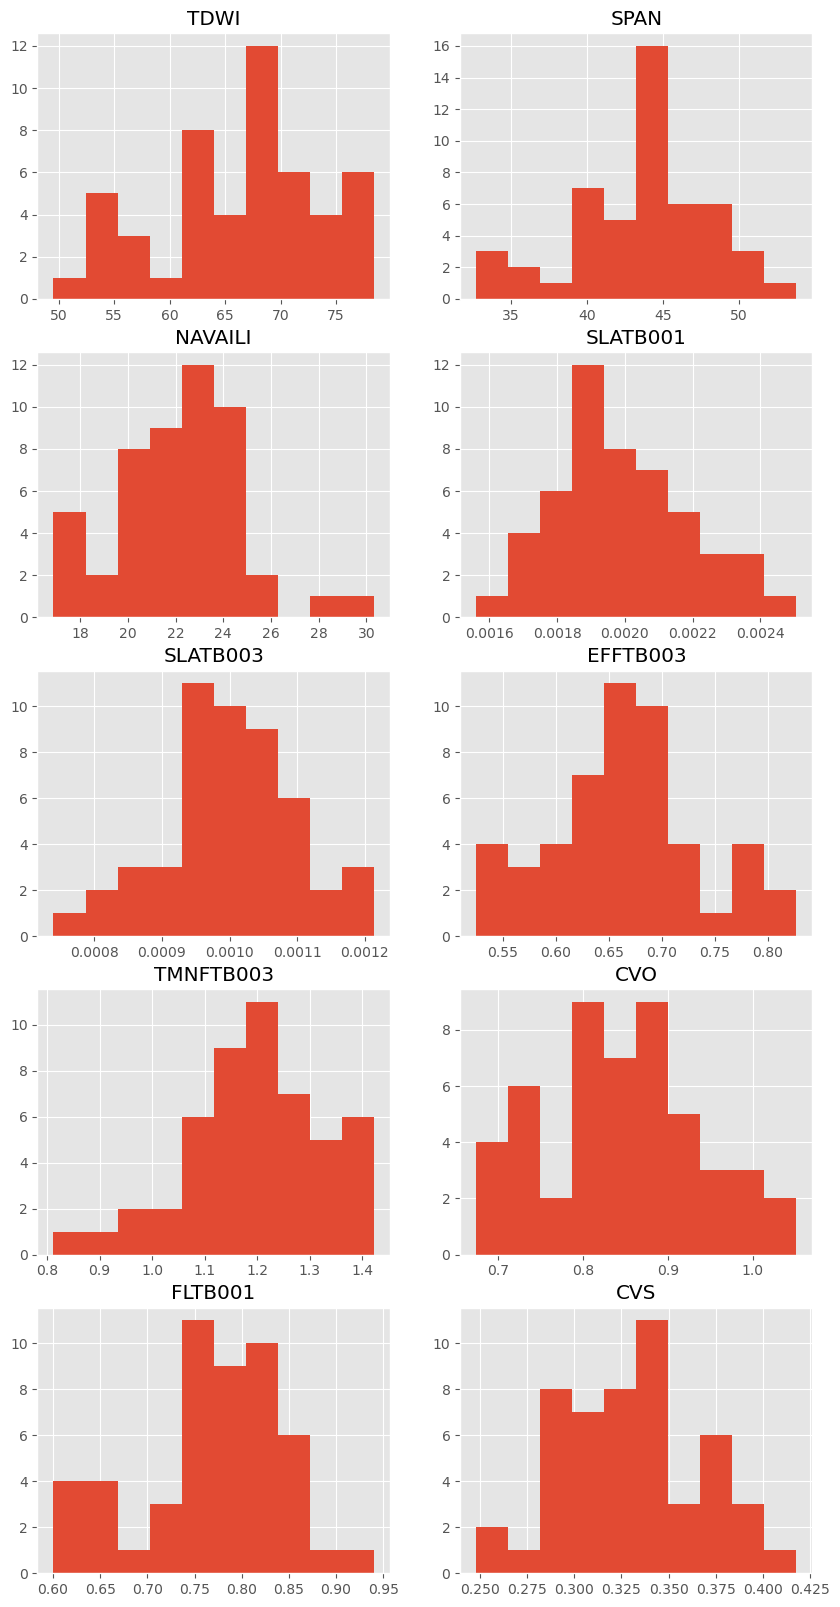

In [141]:
tdwi = param_df.iloc[1]["TDWI"]
span = param_df.iloc[1]["SPAN"]

# 需要调整的参数集
# param_set = pd.read_csv("./data/opt/DA/ZD_DA1.csv", index_col=0)
param_name = ['SPAN',
              'TDWI',
              ]
override_parameters = {}
# 初始条件
override_parameters["TDWI"] = add_gaussian_noise(tdwi, (ensemble_size, ), 1, 0.1)

# override_parameters["WAV"] = np.random.normal(18., 1.5, (ensemble_size))
# override_parameters["NAVAILI"] = np.random.normal(20.5, 0.5, (ensemble_size))
# 参数
override_parameters["SPAN"] = add_gaussian_noise(span, (ensemble_size, ), 1, 0.1)
# override_parameters["SLATB001"] = np.random.normal(0.002834115, 0.000153716 ,(ensemble_size))
# override_parameters["SLATB003"] = np.random.normal(0.001443546, 0.0000451982, (ensemble_size))
# override_parameters["TMNFTB003"] = np.random.normal(1.110052116, 0.033887947, (ensemble_size))
# override_parameters["EFFTB003"] = np.random.normal(0.508812352, 0.023041403, (ensemble_size))
# override_parameters["NMAXLV_TB007"] = np.random.normal(0.010378854, 0.00066446, (ensemble_size))
# override_parameters["NCRIT_FR"] = np.random.normal(0.750958689, 0.020258971, (ensemble_size))
# for each in param_set.columns:
#     override_parameters[each] = np.random.normal(param_set.loc[0, each], param_set.loc[1, each], (ensemble_size))

par_std = pd.read_csv("./data/opt/DA/opt_ZDN180_DA_result3.csv", index_col=0)
par_std.sort_values(by="rmse", ascending=True, inplace=True)
param_name = par_std.columns
param_name = param_name.to_list()[1: ]

idx = 1
for each in param_name:
    value = param_df.iloc[idx][each]
    frac = par_std.iloc[0][each]

    override_parameters[each] = add_gaussian_noise(value, (ensemble_size, ), 1, 0.1)


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,20))
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)


### 3.3初始化集合

In [142]:
ensemble = []
parameters = overwrite_para(parameters, p_value)
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    tmp_dict = dict()
    for par, distr in override_parameters.items():
        tmp_dict[par] = distr[i]
    p = overwrite_para(p, tmp_dict)
    member = Wofost80_NWLP_FD(p, wdp, agro)
    ensemble.append(member)

### 3.4 Implementing the data assimilation itself
First, we define if we want to see detailed output, disabling output makes the notebook more compact as long tables will not be shown.

In [143]:
show_output = False

**以下为3.4.1-3.4.6的所有代码**

In [144]:
while len(observations_for_DA):   
    day, obs = observations_for_DA.pop(0)
    for member in ensemble:
        member.run_till(day)
    print("Ensemble now at day %s" % member.day)
    print("%s observations left!" % len(observations_for_DA))

    collected_states = []
    for member in ensemble:
        t = {}
        for state in variables_for_DA:
            t[state] = member.get_variable(state)
        collected_states.append(t)
    df_A = pd.DataFrame(collected_states)
    A = np.matrix(df_A).T
    df_A if show_output else None

    P_e = np.matrix(df_A.cov())
    df_A.cov() if show_output else None

    perturbed_obs = []
    for state in variables_for_DA:
        (value, std) = obs[state]
        d = np.random.normal(value, std, (ensemble_size))
        perturbed_obs.append(d)
    df_perturbed_obs = pd.DataFrame(perturbed_obs).T
    df_perturbed_obs.columns = variables_for_DA
    D = np.matrix(df_perturbed_obs).T
    R_e = np.matrix(df_perturbed_obs.cov())
    df_perturbed_obs if show_output else None

    # Here we compute the Kalman gain
    H = np.identity(len(obs))
    K1 = P_e * (H.T)
    K2 = (H * P_e) * H.T
    K = K1 * ((K2 + R_e).I)
    K if show_output else None

    # Here we compute the analysed states
    Aa = A + K * (D - (H * A))
    df_Aa = pd.DataFrame(Aa.T, columns=variables_for_DA)
    df_Aa if show_output else None

    for member, new_states in zip(ensemble, df_Aa.itertuples()):
        r1 = member.set_variable("LAI", new_states.LAI)
        r2 = member.set_variable("TAGP", new_states.TAGP)


for member in ensemble:
    member.run_till_terminate()

Ensemble now at day 2021-07-08
7 observations left!
Ensemble now at day 2021-07-18
6 observations left!
Ensemble now at day 2021-07-29
5 observations left!
Ensemble now at day 2021-08-06
4 observations left!
Ensemble now at day 2021-08-15
3 observations left!
Ensemble now at day 2021-08-27
2 observations left!
Ensemble now at day 2021-09-07
1 observations left!
Ensemble now at day 2021-09-20
0 observations left!


#### 3.4.1 Move the ensemble forward in time until the first analysis step
First we take the first observation from the set of observations. Next, we will instruct each ensemble member to move forward in time (simulate the crop) up till the date where the first observation is available. The latter is done with the `run_till()` function on each member.

In [719]:
day, obs = observations_for_DA.pop(0)
for member in ensemble:
    member.run_till(day)
print("Ensemble now at day %s" % member.day)
print("%s observations left!" % len(observations_for_DA))

IndexError: pop from empty list

#### 3.4.2 Retrieve the states from the ensemble
All ensemble members have now reached the date of the first observation. We will now collect the simulated leaf area index (LAI) and soil moisture (SM) from the ensemble and collect them in the list `collected_states`. We will then convert the list  into a pandas dataframe `df_A` which will be converted to the matrix $A$. The dataframe `df_A` is for visualising the results while the matrix $A$ will be used for mathematical operations.

In [109]:
collected_states = []
for member in ensemble:
    t = {}
    for state in variables_for_DA:
        t[state] = member.get_variable(state)
    collected_states.append(t)
df_A = pd.DataFrame(collected_states)
A = np.matrix(df_A).T
df_A if show_output else None

### 3.4.3 Compute covariance within ensemble states

In order to compute the Kalman gain we need to calculate the (co)variance matrix of the simulated states within the ensemble.  This can be easily accomplished with the `cov()` function on the pandas dataframe. By convention we call the covariance matrix $P_e$.

In [110]:
P_e = np.matrix(df_A.cov())
df_A.cov() if show_output else None

### 3.4.4. Calculate perturbed observations and their mean and covariance

The purpose of the simulated ensemble is to treat the simulated states as a random variable. In the same way, we need to treat the observed states as a random variable. We can accomplish this by generating a distribution of perturbed observations with a mean and standard deviation defined by the observed value and its uncertainty. 

In this code, the perturbed observations are first collectected in the dataframe `df_perturbed_obs` which is then converted in the matrix $D$ and its covariance matrix $R_e$.

In [111]:
perturbed_obs = []
for state in variables_for_DA:
    (value, std) = obs[state]
    d = np.random.normal(value, std, (ensemble_size))
    perturbed_obs.append(d)
df_perturbed_obs = pd.DataFrame(perturbed_obs).T
df_perturbed_obs.columns = variables_for_DA
D = np.matrix(df_perturbed_obs).T
R_e = np.matrix(df_perturbed_obs.cov())
df_perturbed_obs if show_output else None

### 3.4.5 Apply the Kalman filter equations
First we compute the Kalman gain $$K = \frac{P_e H^T}{(H P_e H^T + R_e)}$$

The Kalman gain weights the uncertainty of the simulated values (by its variance $P_e$) against the uncertainty of the observations (by its variance $R_e$). Here, $H$ is the *measurement operator* (also called *observation matrix*) which specifies the (linear) relationship between the simulated state and the observed quantity. In our case, $H$ is an identity matrix because LAI and SM are observed directly and no conversion from state to observation is needed.

Next we compute the Kalman state updates:
$$A^a = A + K (D - H A)$$

Here the matrix with updated values of the states $A^a$ (also called the *analysed* states) is computed by augmenting the old states $A$ with the difference between the observed $D$ and simulated $A$ values multiplied by the Kalman gain $K$. The part of the equation $K (D - H A)$ is called the *innovations*.

The impact of the Kalman gain is most easily understood from the extreme cases for a single state. Let's first assume that the simulation is perfect, this implies that the variance $P_e$ is zero as the numerator is zero. In that case, the obervations are totally ignored because Kalman gain is zero and the analysed states $A^a$ are equal to the simulated states because the innovations are zero. The other extreme cases is when we assume that the observations are perfect and have variance $R_e$ of zero. In this case, the Kalman gain is '1' and the innovations are such that the analysed state $A^a$ is augmented to exactly match the observations.

In [112]:
# Here we compute the Kalman gain
H = np.identity(len(obs))
K1 = P_e * (H.T)
K2 = (H * P_e) * H.T
K = K1 * ((K2 + R_e).I)
K if show_output else None

In [113]:
# Here we compute the analysed states
Aa = A + K * (D - (H * A))
df_Aa = pd.DataFrame(Aa.T, columns=variables_for_DA)
df_Aa if show_output else None

### 3.4.6 Update the ensemble to reflect the new state
We have computed the new states for each ensemble member which are collected in the dataframe `df_Aa`. We now need to update each WOFOST ensemble member to update its internal state to the value in `df_Aa`. This update is done with the `set_variable(<varname>, <value>)` method that is available on each WOFOST object. 

Note that *setting* a variable is much more difficult than *getting* a variable because in order to change an internal state it is often required to change other related states as well. For example, LAI in WOFOST is not a true state but a state which is derived from the leaf biomass. In order to update the LAI we need to update the leaf biomass as well. Similarly, for updating soil moisture it is not only required to update the volumetric water contect in the rooted zone, but also the amount of water in the root zone. Moreover, some of the totals need to be adapted in order to have a closing water balance. This means that the logic for state updates is highly depending on the particular model structure and needs to be implemented for each state variable individually.

Technically, this is implemented by implementing a object method `_set_variable_<varname>()` that implements all logic to update the state variable `varname`. For example, for LAI updates a method `_set_variable_LAI()` is implemented on the leaf_dynamics module that will be called by the `set_variable` method in order to update the LAI.

In [114]:
for member, new_states in zip(ensemble, df_Aa.itertuples()):
    r1 = member.set_variable("LAI", new_states.LAI)
    r2 = member.set_variable("TAGP", new_states.TAGP)

### 3.4.7 Repeat steps 2.4.1 to 2.4.6 for the next analysis step (observation)

We now need to repeat the above steps for each observation available and until the cell under 2.4.1 reports `0 observations left!`

*Tip*: You can switch of the output in order to have a more compact notebook.


### 3.4.8 Run all the ensemble members until the end of the growing season

Finally, we can run the WOFOST ensemble until the end of the growing season using the `run_till_terminate()` call.


In [ ]:
for member in ensemble:
    member.run_till_terminate()

## 4绘图

### 4.1 从集合中提取数据

In [145]:
results = []
for member in ensemble:
    member_df = pd.DataFrame(member.get_output()).set_index("day")
    results.append(member_df)

**计算误差**

In [146]:
i = 0
rmse_list = list()
for member_df in results:
    diff = member_df.LAI - obs_DA.LAI_ML
    obj_func = np.sqrt(np.mean(diff ** 2))
    obj_func = obj_func / np.mean(obs_DA.LAI_ML)

    diff1 = member_df.TAGP - obs_DA.TAGP_ML
    obj_func1 = np.sqrt(np.mean(diff1 ** 2))
    obj_func1 = obj_func / np.mean(obs_DA.TAGP_ML)
    nRMSE = 0*obj_func + 1*obj_func1

    rmse_list.append([i, nRMSE])
    i += 1

df_rmse = pd.DataFrame(rmse_list, columns=["id", "rmse"])
df_rmse.sort_values(by="rmse", inplace=True)
    

In [147]:
idx_list = df_rmse.id.to_list()

In [148]:
idx_list

[28,
 27,
 23,
 0,
 22,
 44,
 19,
 2,
 46,
 11,
 40,
 18,
 6,
 8,
 34,
 36,
 7,
 21,
 49,
 25,
 16,
 48,
 17,
 10,
 38,
 47,
 26,
 15,
 1,
 29,
 20,
 3,
 35,
 41,
 33,
 32,
 31,
 39,
 12,
 37,
 42,
 24,
 4,
 5,
 30,
 45,
 14,
 13,
 43,
 9]

**计算集合均值**

In [149]:
def cal_ensembel_mean(df_list):
    
    num = 0
    for df in copy.deepcopy(df_list):
        
        df.reset_index(inplace=True)
        try:
            df.insert(loc=0, column="group", value=num)
        except ValueError:
            print("pass")
            pass
        if num == 0:
            concat_df = df
        else:
            concat_df = pd.concat([concat_df, df], axis=0)
        num += 1

    concat_df.reset_index(inplace=True, drop=True)
    concat_df = concat_df.groupby(["day"]).mean()

    return concat_df


### 可视化

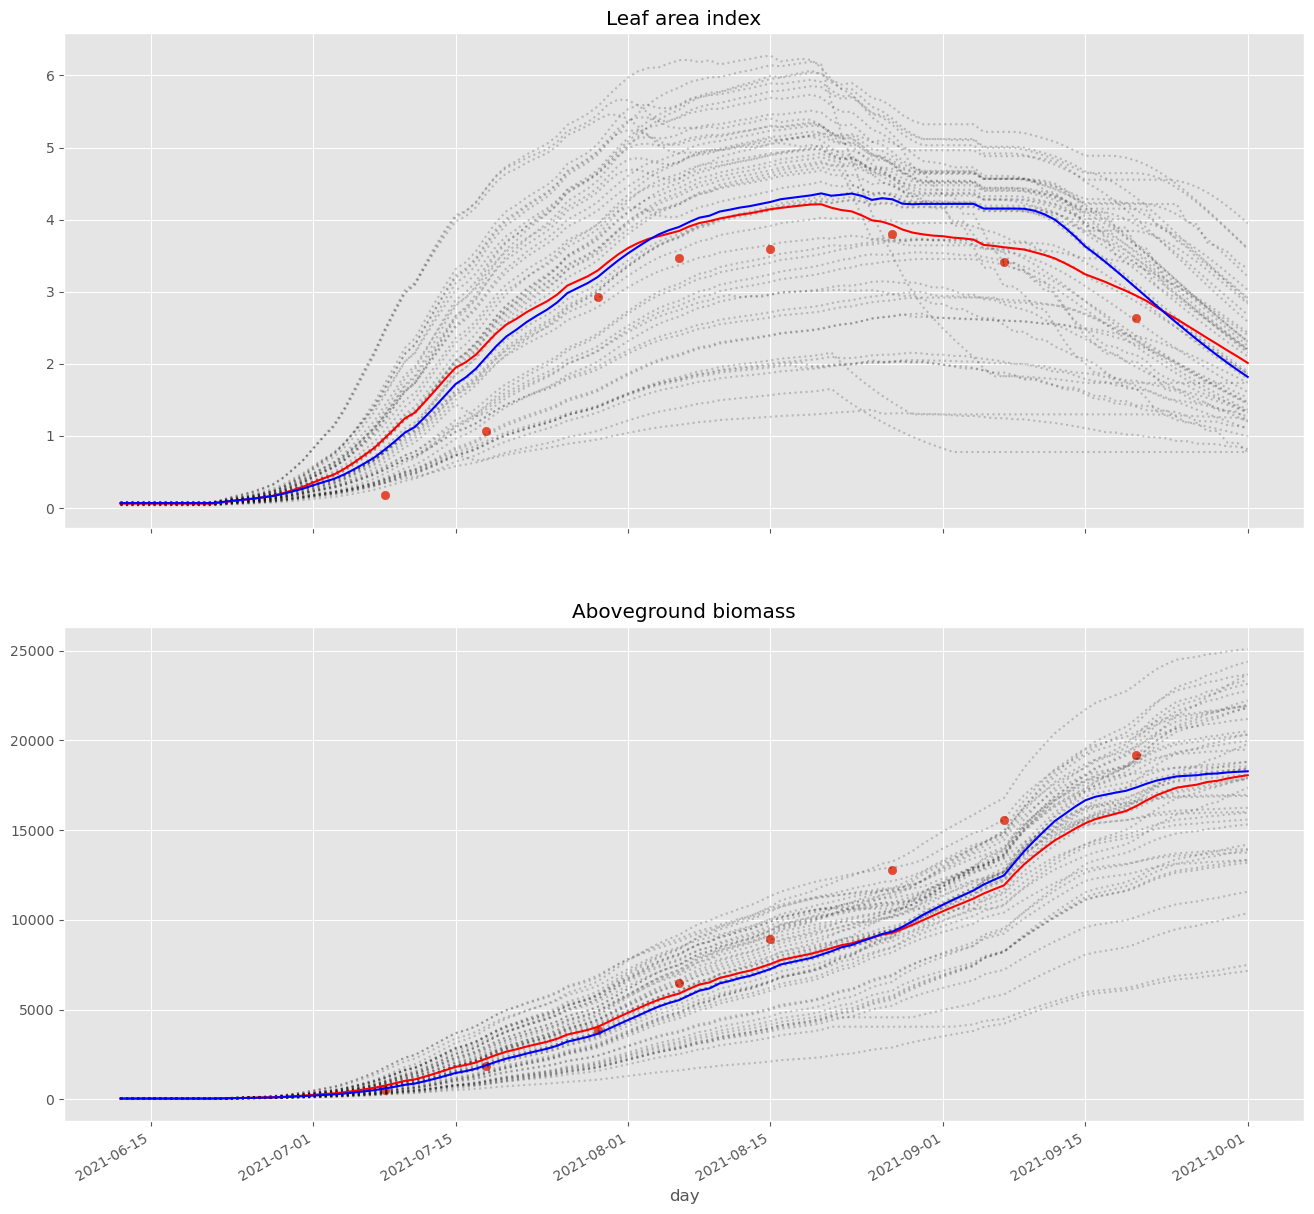

In [150]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,16))
for idx in idx_list:
    member_df = results[idx]
    member_df["LAI"].plot(style="k:", ax=axes[0], alpha=0.2)
    member_df["TAGP"].plot(style="k:", ax=axes[1], alpha=0.2)
axes[0].scatter(dates_of_observation, observed_lai, marker="o")
axes[1].scatter(dates_of_observation, observed_tagp, marker="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Aboveground biomass")
#集合均值
ensembel_mean_df = cal_ensembel_mean(results)
ensembel_mean_df["LAI"].plot(style="r", ax=axes[0])
ensembel_mean_df["TAGP"].plot(style="r", ax=axes[1])

# 模型模拟数据
df_model["LAI"].plot(style="b", ax=axes[0])
df_model["TAGP"].plot(style="b", ax=axes[1])
fig.autofmt_xdate()

In [151]:
twso = list()
for member_df in results:
    twso.append(member_df["TWSO"][-1])

In [459]:
member_df

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,...,KAVAIL,Ndemand,RNuptake,Pdemand,RPuptake,Kdemand,RKuptake,NamountSO,PamountSO,KamountSO
day,,,,,,,,,,,,,,,,,,,,,
2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335000,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.318952,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.343243,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.415367,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23,1.931158,2.036997,13393.862855,7650.430696,1699.398187,4044.033972,933.388981,0.075043,100.0,0.332838,...,160.661722,2.267165,2.267165,5.063014,0.0,0.0,0.0,88.306955,32.574807,34.563952
2022-09-24,1.952105,1.977770,13505.162165,7761.730006,1699.398187,4044.033972,933.388981,0.072104,100.0,0.331907,...,158.394557,2.172833,2.172833,5.337678,0.0,0.0,0.0,90.837264,33.129002,35.697815
2022-09-25,1.973299,1.916147,13598.528127,7855.095968,1699.398187,4044.033972,933.388981,0.142584,100.0,0.331030,...,156.221724,2.126893,2.126893,5.554955,0.0,0.0,0.0,93.341258,33.627777,36.785072
